# Copyright

<PRE>
Copyright (c) Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Using this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Assignment: RNN text generation with your favorite book


## 1. Dataset
- Download your favorite book from https://www.gutenberg.org/
- Combine all sonnets into a single text source.  
- Split into training (80%) and validation (20%).  

In [1]:
!pip install transformers

In [2]:
from transformers import BertTokenizer
import numpy as np
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.activations import softmax



# Load the BERT tokenizer (uncased = lowercase)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
with open("CrimeAndPunishment.txt", "r") as file:
    book = file.read()
    # print(book)

#get sonnets?
start = book.find("*** START OF THE PROJECT GUTENBERG EBOOK CRIME AND PUNISHMENT ***")  # book begins
end = book.find("*** END OF THE PROJECT GUTENBERG EBOOK CRIME AND PUNISHMENT ***") # book ends

offset = len("*** START OF THE PROJECT GUTENBERG EBOOK CRIME AND PUNISHMENT ***")
book = book[start+offset:end].strip()

## 2. Preprocessing
- Convert text to lowercase.  
- Remove punctuation (except basic sentence delimiters).  
- Tokenize by words or characters (your choice).  
- Build a vocabulary (map each unique word to an integer ID).

In [4]:
import re

def clean_text(lines):
    text = [re.sub(r"[^\w\s\.\!\?']", "", line) for line in lines]
    text = [word.lower() for word in text]
    return text

In [49]:
words = book.split()

words = clean_text(words)
book = " ".join(words)
# book

In [6]:
tokens = tokenizer.tokenize(book)  # tokenizing full cleaned book
inputIDs = tokenizer.convert_tokens_to_ids(tokens)

splitIDX = int(0.8 * len(inputIDs))
trainIDs = inputIDs[:splitIDX]
valIDs = inputIDs[splitIDX:]

In [7]:
# inputIDs

In [8]:
# tokens

## 3. Embedding Layer in Keras
Below is a minimal example of defining an `Embedding` layer:
```python
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    input_dim=vocab_size,     # size of the vocabulary
    output_dim=128,           # embedding vector dimension
    input_length=sequence_length
)
```
- This layer transforms integer-encoded sequences (word IDs) into dense vector embeddings.

- Feed these embeddings into your LSTM or GRU OR 1D CNN layer.

In [9]:
vocabSize = tokenizer.vocab_size
sequenceLength = 30


def createSequences(input_ids, seq_length):
    X = []
    y = []
    for i in range(len(input_ids) - seq_length):
        X.append(input_ids[i:i+seq_length])
        y.append(input_ids[i+seq_length])
    return np.array(X), np.array(y)

X_train, y_train = createSequences(trainIDs, sequenceLength)
X_val, y_val = createSequences(valIDs, sequenceLength)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (200166, 30), y_train shape: (200166,)
X_val shape: (50019, 30), y_val shape: (50019,)


In [10]:
# X_train = np.array(train_chunks)

## 4. Model
- Implement an LSTM or GRU or 1D CNN-based language model with:
  - **The Embedding layer** as input.
  - At least **one recurrent layer** (e.g., `LSTM(256)` or `GRU(256)` or your custom 1D CNN).
  - A **Dense** output layer with **softmax** activation for word prediction.
- Train for about **5–10 epochs** so it can finish in approximately **2 hours** on a standard machine.


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


model = Sequential()
model.add(Embedding(
    input_dim=vocabSize,     # size of the vocabulary
    output_dim=128,           # embedding vector dimension
    # input_length=sequence_length
))
model.add(LSTM(25, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dense(vocabSize, activation='softmax'))

In [12]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 5. Training & Evaluation
- **Monitor** the loss on both training and validation sets.
- **Perplexity**: a common metric for language models.
  - It is the exponent of the average negative log-likelihood.
  - If your model outputs cross-entropy loss `H`, then `perplexity = e^H`.
  - Try to keep the validation perplexity **under 50** if possible.

In [14]:
es = EarlyStopping(monitor='val_loss',
                           patience=2,
                           restore_best_weights=True,
                           verbose=1) # early stopping

In [15]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    callbacks=[es],
                    batch_size=64,
                    epochs=6)

Epoch 1/7
3128/3128 ━━━━━━━━━━━━━━━━━━━━ 1277s 406ms/step - accuracy: 0.0707 - loss: 6.6240 - val_accuracy: 0.1227 - val_loss: 5.6054
Epoch 2/7
3128/3128 ━━━━━━━━━━━━━━━━━━━━ 1245s 394ms/step - accuracy: 0.1437 - loss: 5.3296 - val_accuracy: 0.1739 - val_loss: 5.2241
Epoch 3/7
3128/3128 ━━━━━━━━━━━━━━━━━━━━ 1332s 410ms/step - accuracy: 0.1812 - loss: 4.8586 - val_accuracy: 0.1916 - val_loss: 5.0937
Epoch 4/7
3128/3128 ━━━━━━━━━━━━━━━━━━━━ 1345s 411ms/step - accuracy: 0.2034 - loss: 4.5618 - val_accuracy: 0.2004 - val_loss: 5.0588
Epoch 5/7
3128/3128 ━━━━━━━━━━━━━━━━━━━━ 1217s 389ms/step - accuracy: 0.2174 - loss: 4.3332 - val_accuracy: 0.2047 - val_loss: 5.0799
Epoch 6/7
3128/3128 ━━━━━━━━━━━━━━━━━━━━ 1244s 396ms/step - accuracy: 0.2292 - loss: 4.1322 - val_accuracy: 0.2075 - val_loss: 5.1320
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 4.


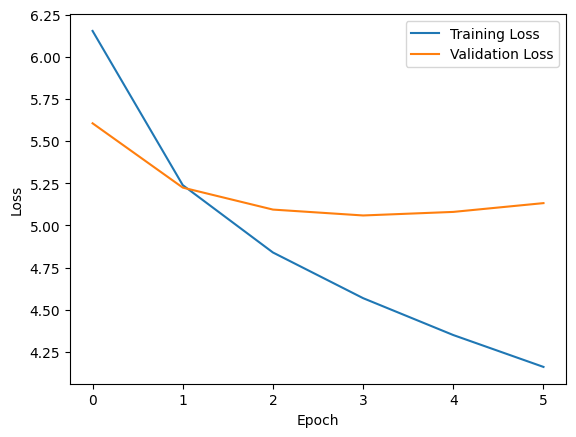

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

train_perplexity = np.exp(final_train_loss)
val_perplexity = np.exp(final_val_loss)

print(f"Train Perplexity: {train_perplexity:.2f}")
print(f"Validation Perplexity: {val_perplexity:.2f}")

Train Perplexity: 64.11
Validation Perplexity: 169.35


In [21]:
val_loss, val_acc = model.evaluate(X_val, y_val)
val_perplexity = np.exp(val_loss)

print("Validation Loss: ", val_loss)
print("Validation Accuracy: ", val_acc)
print("Validation Perplexity: ", val_perplexity)

1564/1564 ━━━━━━━━━━━━━━━━━━━━ 106s 68ms/step - accuracy: 0.2043 - loss: 4.9216
Validation Loss:  5.05877685546875
Validation Accuracy:  0.2004038393497467
Validation Perplexity:  157.39787818131103


## 6. Generation Criteria
- After training, generate **two distinct text samples**, each at least **50 tokens**.
- Use **different seed phrases** (e.g., “love is” vs. “time will”).

In [40]:
def generate_text(seed_text, num_tokens=50):
    ids = tokenizer.encode(seed_text, add_special_tokens=False)
    ids = ([0]*(sequenceLength-len(ids)) + ids)[-sequenceLength:]

    for _ in range(num_tokens):
        inp = np.array(ids[-sequenceLength:])[None, :]
        next_id = model.predict(inp, verbose=0)[0].argmax()
        ids.append(next_id)

    return tokenizer.decode(ids, clean_up_tokenization_spaces=True)

In [48]:
sample1 = generate_text("the crime", num_tokens=50)
sample1Words = sample1.split()
sample1Words = sample1Words[-51::]
sample1 = " ".join(sample1Words)

print("Sample 1:")
print(sample1)

Sample 1:
the crime. the old woman was a great deal of the other and the whole one had been a great deal of the other and the whole one had been a great deal of the other and the whole one had been a great deal of the other and the whole


In [47]:
sample2 = generate_text("do not forget", num_tokens=50)
sample2Words = sample2.split()
sample2Words = sample2Words[-52::]

sample2 = " ".join(sample2Words)

print("Sample 2:")
print(sample2)

Sample 2:
do not forget the other and the other time. the man was a great deal of the other and the whole one had been a great deal of the other and the whole one had been a great deal of the other and the whole one had been a great deal of
